In [ ]:
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")

# uplifitng

### 데이터 변수 설명
* recency : 마지막 구매 후 개월
* history: 과거 구매의 $value
* used_discount: 할인 사용 여부
* used_bogo: 재구매 했는지 여부
* zip_code: Suburban/Urban/Rural과 같은 우편번호 클래스
* is_referral: 추천 채널에서 고객을 획득했는지 여부를 나타냅니다.
* channel: 고객이 사용하는 채널, Phone/Web/Multichannel
* offer: 고객에게 전송된 제안, Discount/But One Get One(원플러스원)/No Offer
* conversation : (1-구매 , 0-X)

### Content

This dataset show customer's brief information,
historical use of discount or BOGO(Buy One Get One) promotion,
offer has been made, and the conversion result(buy or not).
The conversion average value = $25

----
데이터 설명에 따르면 discount 나 bogo offer를 받은 고객들은 Treatment(타겟군) 이고 나머지는 통제집단으로 볼 수 있겠다.


In [ ]:
# !kaggle datasets download -d davinwijaya/customer-retention
!unzip -o /content/customer-retention.zip -d /content

Archive:  /content/customer-retention.zip
  inflating: /content/data.csv       


In [110]:
df= pd.read_csv('/content/uplift.csv')

In [ ]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


# 데이터탐색

In [ ]:
df.info()

In [ ]:
# 범주형 변수 확인
df.describe(include = np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [ ]:
# 명목형 변수 값들 count /  데이터설명에 명시된 것 말고 이외의 값이 있나 확인해보자
zip_count = df['zip_code'].value_counts()
channel_count = df['channel'].value_counts()
offer_count = df['offer'].value_counts()

print(zip_count)
print(channel_count)
print(offer_count)



Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


In [111]:
# 편의상 conversion 을 target 으로
# offer 를 treatment로 바꿔주자.

df = df.rename(columns={'conversion': 'target','offer':'treatment'})
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1}) # 0 인경우 control, -1,1 인경우 Treatment


* treatment(-1) = BOGO 원플러스원 광고를 받은 실험군
* treatment(1) = 할인 광고를 받은 실험군
* treatment(0) = 대조군



In [113]:
df['treatment'].value_counts()

-1    21387
 1    21307
 0    21306
Name: treatment, dtype: int64

In [114]:
# 범주형 변수 one hot encoding
df_model = pd.get_dummies(df)


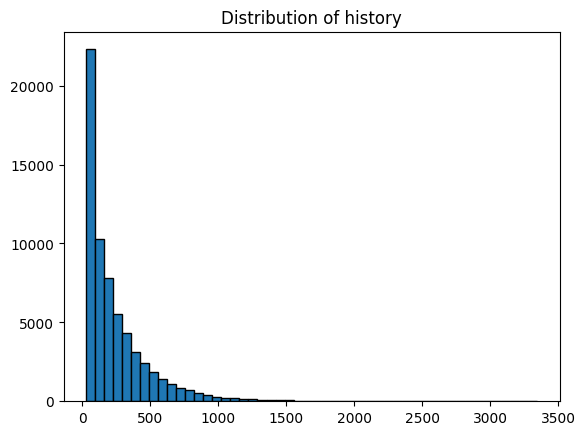

In [ ]:
# recency  history
# 히스토리의 경우 어느정도 이상치값이 있다.
import matplotlib.pyplot as plt

plt.hist(df['history'], bins=50, edgecolor='black')  # 20개의 구간으로 나누어 히스토그램 그리기
plt.title('Distribution of history')
plt.show()

In [115]:
# target 변수
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True) # 원플원 광고를 받은 실험군과 대조군 DATA
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True) # 할인 광고를 받은 실험군과 대조군 DATA

In [116]:
df_model_bogo['treatment'] = df_model_bogo['treatment'].replace(-1, 1)

In [124]:
df_model['treatment'] = df_model['treatment'].replace(-1,1)

## 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities. The calibration of model probabilities is described perfectly in [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Two independent models

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

1. Train the first model using the treatment set.
2. Train the second model using the control set.
3. Inference: subtract the control model scores from the treatment model scores.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila.png" alt="Two Models vanila"/>
</p>

In [125]:
train, test  = train_test_split(df_model, test_size=0.2, random_state=42, stratify = df_model['treatment'])

# 주어진 피처 리스트
features = ['recency',	'history',	'used_discount',	'used_bogo',	'is_referral'	,	'zip_code_Rural',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Multichannel',	'channel_Phone'	,'channel_Web']

# 피처 및 타겟을 설정하고 데이터를 분할
X = train[features]  # train 데이터프레임을 사용하여 피처 추출
y = train['target']
treatment = train['treatment']

# 데이터 분할
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

[LightGBM] [Info] Number of positive: 1450, number of negative: 12249
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 13699, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.105847 -> initscore=-2.133881
[LightGBM] [Info] Start training from score -2.133881
[LightGBM] [Info] Number of positive: 4539, number of negative: 22722
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 27261, number of used features: 11
[LightGBM] [Info

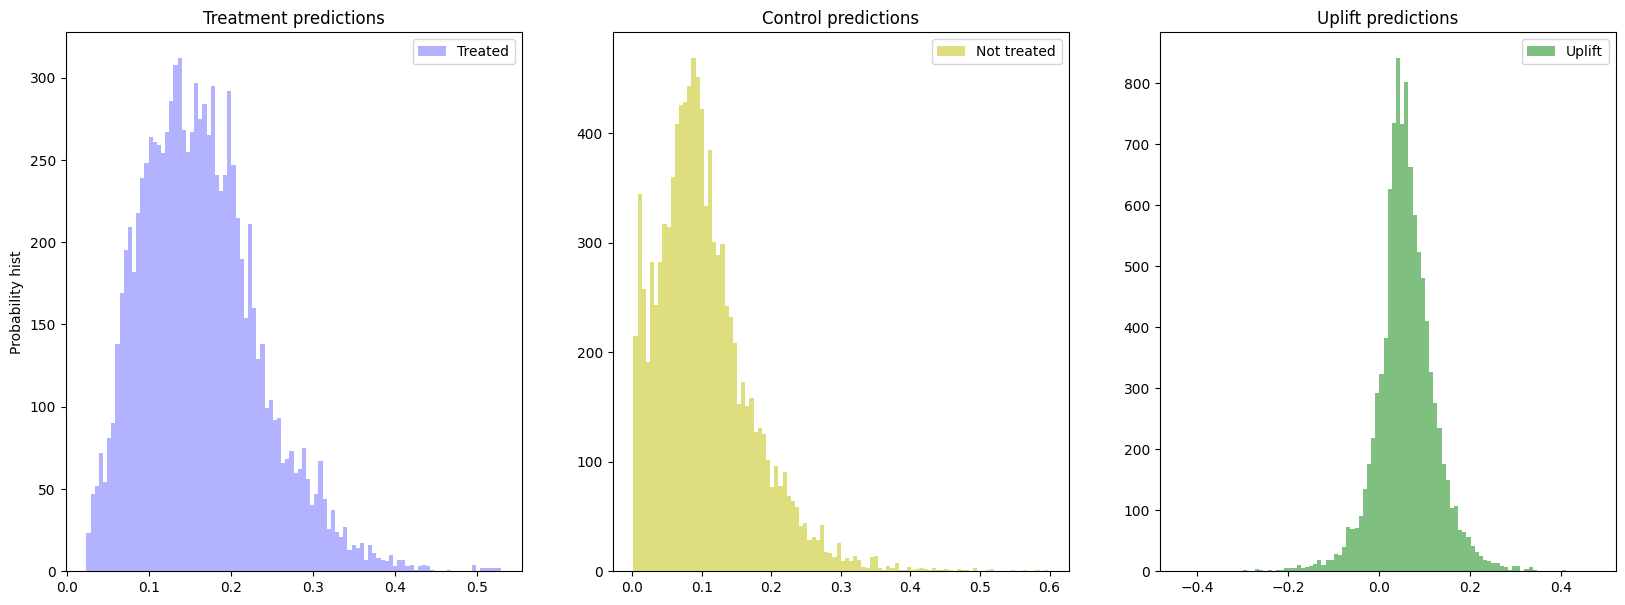

In [126]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss'
}

# TwoModels 모델 설정
tm = TwoModels(
    estimator_trmnt=lgb.LGBMClassifier(**lgb_params),
    estimator_ctrl=lgb.LGBMClassifier(**lgb_params),
    method='vanilla'
)

# 3. 모델 학습
tm = tm.fit(
    X_train, y_train, treat_train
)

# 4. 업리프팅 예측
uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

# 5. 업리프팅 측정
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,TwoModels,0.073687


In [ ]:
df_uplift = pd.DataFrame({'uplift_score': np.array(uplift_tm)})
df_uplift

,uplift_score
0,0.031237
1,0.001270
2,-0.054862
3,0.072842
4,0.084649
...,...
6813,0.089104
6814,0.103594
6815,-0.036275
6816,0.299455


In [127]:
df_model = df_model[features]

In [128]:
uplift_full = tm.predict(df_model)  # 적용
df_model['score'] = uplift_full

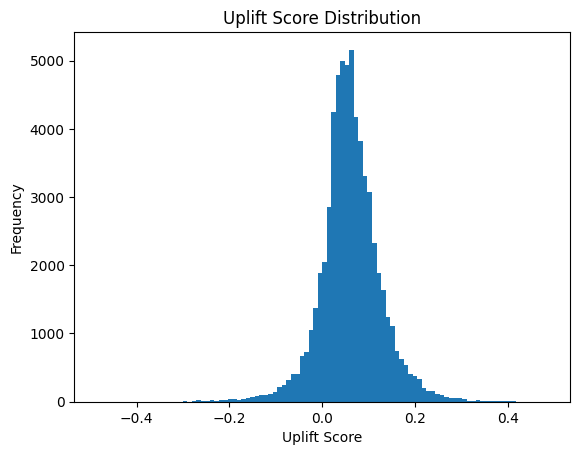

In [130]:
plt.hist(df_model['score'], bins=100)
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Uplift Score Distribution')
plt.show()

In [154]:
#CN:
df['target_class'] = 0
#CR:
df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1
#TN:
df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2
#TR:
df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3

df['target_class'].value_counts()

2    35562
0    19044
3     7132
1     2262
Name: target_class, dtype: int64

In [134]:
# score 가 0 이상인

score_count = df_model[df_model['score'] >= 0]['score'].count()
total_count = len(df_model)

positive_score_ratio = score_count / total_count
print("Positive Score Ratio:", positive_score_ratio)


Positive Score Ratio: 0.871734375


In [160]:
# 임계값 설정
threshold = 0

# Pesuadables 그룹으로 간주되는 데이터 개수 계산
pesuadables_count = len(df_model[df_model['score'] >= threshold])

# 전체 데이터 개수
total_count = len(df_model)

# Pesuadables 그룹의 비율 계산
pesuadables_ratio = pesuadables_count / total_count

print("Pesuadables 그룹 비율:", pesuadables_ratio)

Pesuadables 그룹 비율: 0.0143125


###  score를 기준으로 세그먼트를 어떻게 나눠야하지?

>✔️ skewness 는 높지 않지만 약 87% 유저의 score가 0.0 이상을 기록했다.
업리프팅 사분면에 따라 세그먼터를 나눠야하는데, 어떤 기준으로 나눠야할까..?

> score 가 높을 수록 Pesuadables 고객으로 봐야하는것 같은데  그 높다는 기준을 어디로 잡아야 하는지 헷갈린다!

### 🤔결론!
일단 크게 치우쳐지지 않고,
* score 가 0 이상인경우 87%
* 0.1 인경우, 23%
* 0.2 인 경우 2.5%
* 0.3 부터는 0.2 %로 매우 적다.
* scroe가 음수인 경우는 13% 가 있음.

크게 4가지로 분류할 수 는 없을 것 같지만, 확실한건 해당 광고시 부정적인 영향을 끼칠 세그먼트는 확실히 나눌 수 있다는것!

> 일단은 0 =< surething < 0.1  인경우 SureThings \
0.1 이상인경우 Persuadables , 음수인경우 Lost Causes 로 나누었다.



In [162]:
def segment_customers(score):
    if score >= 0 and score < 0.1:
        return "Sure Things"
    elif score >= 0.1:
        return "Persuadables"
    elif score >= -0.1 and score < 0:
        return "Lost Causes"
    else:
        return "Sleeping dogs"

df_model['segment'] = df_model['score'].apply(segment_customers)
df_model['segment'].value_counts()

Sure Things      41285
Persuadables     14506
Lost Causes       7293
Sleeping dogs      916
Name: segment, dtype: int64

In [136]:
df_model['segment'].value_counts()

Sure Things      55791
Sleeping Dogs     8209
Name: segment, dtype: int64

# New  Data

데이터가 너무 크다. kaggle api로 받아오자

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omgcs7750","key":"8be0431ae68897c04d1934bc7669c90c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arashnic/uplift-modeling

 96% 313M/324M [00:01<00:00, 256MB/s]
100% 324M/324M [00:01<00:00, 233MB/s]


In [ ]:
!unzip -o /content/uplift-modeling.zip -d /content

Archive:  /content/uplift-modeling.zip
  inflating: /content/criteo-uplift-v2.1.csv  


In [ ]:
df = pd.read_csv('/content/criteo-uplift-v2.1.csv')


# data info (binary)

* treatment (1) : 실험군, target
* treatment (0) : 대조군, control

* conversion : 전환 여부
* visit : 방문여부
* exposure : 노출여부? 인데 광고 노출을 받은걸 의미하는것 같다. treatment effect, whether the user has been effectively exposed . 즉 캠페인, 마케팅을 받았는지

treatment 의 경우 treatment 와 control 여부를 나타내는 변수 이며
exposure 은 완벽하게 마케팅 광고에 노출되었는지 여부를 나타낸다.

위 데이터에서 실험군 이지만 노출을 받지 않은 경우도 있다. 편의상  exposure 까지 받았을 때, treatment 라고 해야할것 같다. 즉, exposure =1 treatment =1 인 경우 를 treatment 로





In [ ]:
df.sample(100)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
9168545,12.616365,10.059654,8.983713,4.679882,10.280525,4.115453,0.294443,4.833815,3.843683,13.190056,5.300375,-0.168679,1,0,0,0
10715628,14.523018,10.059654,8.338012,3.907662,10.280525,4.115453,-1.288207,4.833815,3.858041,33.712556,5.300375,-0.168679,1,0,0,0
6490181,22.683053,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
9697044,25.925363,10.059654,8.349674,4.679882,10.280525,4.115453,-1.288207,4.833815,3.955396,16.226044,5.300375,-0.168679,1,0,0,0
9936232,23.966730,10.059654,8.632747,4.679882,10.280525,4.115453,-8.281971,4.833815,3.861910,21.416100,5.300375,-0.168679,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841188,23.459432,10.059654,8.789075,4.679882,10.280525,4.115453,-3.282109,4.833815,3.927254,13.190056,5.300375,-0.168679,1,0,0,0
2222041,23.354885,10.059654,8.214383,4.679882,10.280525,4.115453,-10.275874,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1784564,23.171974,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
10428883,26.691794,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0


In [ ]:
df.info()

<Axes: title={'center': 'Pearson Correlation Matrix'}>

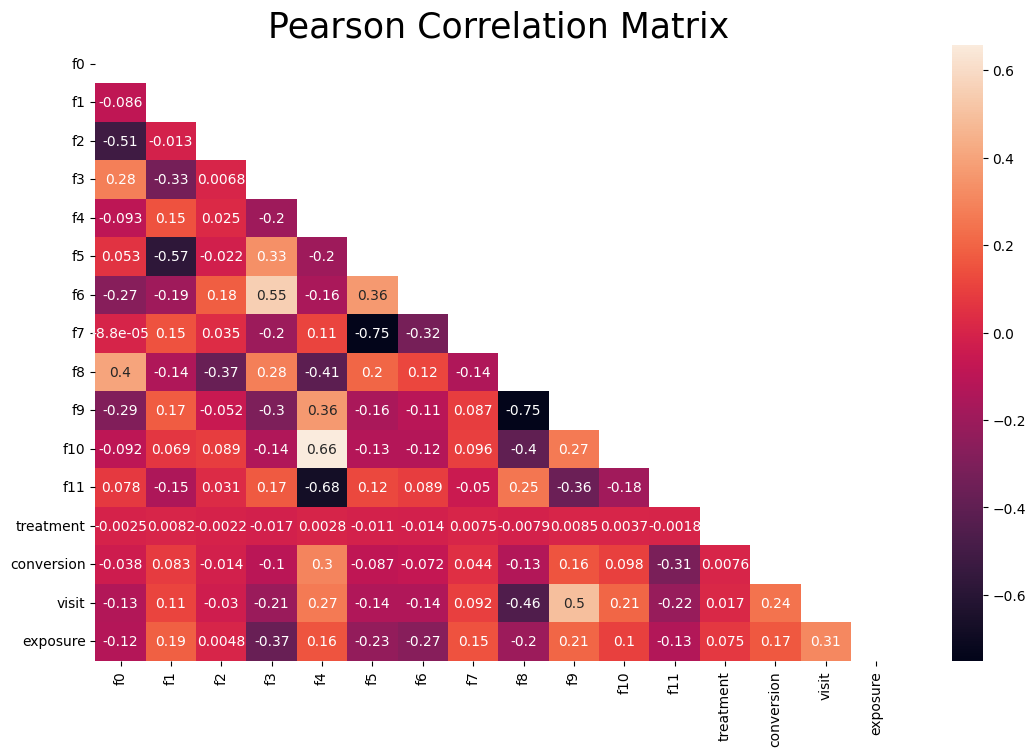

In [ ]:
#Correlation Matrix
f, ax = plt.subplots(figsize=(13, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, mask = mask)

In [ ]:
df.drop(columns=['f5','f8'],inplace = True)

In [ ]:
df['conversion'].value_counts().plot.bar()

* 대조군의 경우 아예 마케팅노출이 안되었고, 실험군의 경우 노출이된경우와 안된경우가 나눠져 있다.

* 대조군 노출 x
* 실험군 노출 x
* 실험군 노출 o

총 3가지

실험군(treatment=1) 그리고 마케팅 노출이 완벽히 안된경우 (exposure = 0) 오히려 대조군 보다 전환율이 떨어진다. 노출이 완벽히 되어야지 전환율에 차이가 있다.

In [ ]:
table_conv = df.groupby(['treatment','exposure']).agg({'conversion':['mean','sum','count']})
table_conv

conversion                 
                         mean    sum     count
treatment exposure                            
0         0          0.001938   4063   2096937
1         0          0.001194  13680  11454443
          1          0.053784  23031    428212

In [ ]:
table_vis = df.groupby(['treatment','exposure']).agg({'visit':['mean','sum','count']})
table_vis

visit                  
                        mean     sum     count
treatment exposure                            
0         0         0.038201   80105   2096937
1         0         0.034861  399314  11454443
          1         0.414538  177510    428212

방문율의 경우도 마찬가지 . 실험군 + 마케팅이 완벽하게 노출 되었을때 큰 상승폭이 있다.

# TEST
> 두 집단의 모비율 차이에 대한 가설 검정

1.conversion전환율

* 대조군 실험군(전체)간에 차이가 있는지
* 대조군 실험군(exposure =1 )간에 차이가 있는지


2.visit 방문율
* 대조군 실험군(전체)간에 차이가 있는지
* 대조군 실험군(exposure = 1 ) 간에 차이가 있는지

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# 전체 대조군 과 실험군 간의 차이 (전환율)

proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].loc[:1],
                  nobs=table_conv.reset_index()[('conversion')]['count'].loc[:1])[1]



6.983951422749621e-165

In [ ]:
# Test between control and exposure group on conversion
#Get the two groups of data
proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].drop(1),
                  nobs=table_conv.reset_index()[('conversion')]['count'].drop(1))[1]



0.0

In [ ]:
#test between control and treatment group on visit
#Get the two groups of data

proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].loc[:1],
                  nobs=table_vis.reset_index()[('visit')]['count'].loc[:1])[1]


5.150161571101964e-128

In [ ]:
#Test between control and exposure group on visit
#Get the two groups of data
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].drop(1),
                  nobs=table_vis.reset_index()[('visit')]['count'].drop(1))[1]

0.0

> 결과) exposure 했을 떄 , 방문율, 전환율 모두 차이가 있고,  유의수준 5%하에  유의확률 p값이 0.05보다 작음, 유의미한 차이가 있다고 볼 수 있다.

> 업리프팅 모델을 적용하기전 해당 마케팅이 효과가 있는것을 검증 했다!


복귀여부를 visit 으로 볼 거냐, conversion 으로 볼 거냐  y 값을 정해줘야한다. 먼저 visit 을 y 값으로 보고 업리프팅 모델을 진행해보자.

* 광고 처지가 이뤄졌을 때의 전환여부  = target 모델 = treatment 중에서 visit 의 결과

* 광고 처치와 관계없이 자연 전환여부 = control 모델 = treatment = 0 중에서 visit의 결과



In [ ]:
# mask = df[(df['treatment'] == 1 ) & (df['exposure']==0)]
# df_ml = df.drop(mask.index).reset_index().drop(['index','treatment'], axis = 1)

# df_ml.sample(50)

df_visit = df.drop(columns=['conversion'])
# df_visit



# undersampling
* treatment 타겟변수의 불균형

데이터(13M rows) 가 꽤 크기 때문에 undersampling 을 해주는게 더 좋을듯하다.

> ✔️ 실험 그룹과 대조 그룹의 분포가 균형을 이루지 않을 때, 데이터 리웨이팅과 리샘플링을 통해 균형을 맞출 수 있다.  

Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

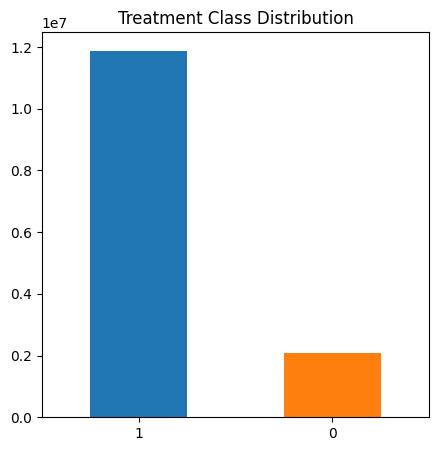

In [ ]:
fig = plt.figure(figsize = (5,5))
target_count = df['treatment'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 10)
plt.xticks(rotation=0)

언더샘플링 하기전에 데이터를 왜 나눠주어야 하지?

>✔️ 모델 평가의 일반성을 보장하기 위해서
언더샘플링을 통해 데이터의 불균형을 해결하면, 학습한 모델은 해당 데이터의 분포와 조건에 특화될 수 있습니다. 따라서 이러한 모델을 일반화하려면 원래 데이터의 분포를 반영하는 테스트 데이터를 사용하여 모델의 성능을 평가해야 한다고 한다.

and 데이터의 누설을 방지할 수 있다.

> ✔️ train 학습 데이터에만 샘플링을 적용해줘야한다.
학습 데이터를 언더샘플링하여 클래스 불균형을 해결하면, 테스트 데이터에 대한 성능 평가는 현실적이고 신뢰할 수 있는 결과를 얻을 수 있습니다. 테스트 데이터는 실제 세계에서의 데이터 분포를 잘 대표해야 하기 때문에 언더샘플링은 테스트 데이터에 적용하지 않습니다.



In [ ]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])


In [ ]:
def random_under(df:pd.DataFrame, feature):

    target = df[feature].value_counts()

    if target.values[0]<target.values[1]:
        under = target.index.values[1]

    else:
        under = target.index.values[0]

    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]

    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)

    return df_1

train = random_under(train, 'treatment')

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy = 'majority')

X_train_resampled, y_train_resampled = undersample.fit_resample(train.drop(columns=['treatment']), train['treatment']) # x : target 이외의 변수들 , y: treatment

# 언더샘플링된 데이터로부터 데이터프레임 생성
train = pd.DataFrame(X_train_resampled, columns=train.drop(columns=['treatment']).columns)
train['treatment'] = y_train_resampled

<Axes: title={'center': 'Treatment Class Distribution'}>

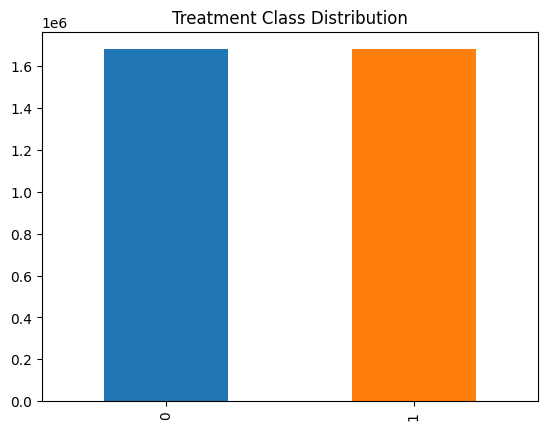

In [ ]:
# 언더샘플링 후의 클래스 분포 확인
target_count_resampled = train['treatment'].value_counts()
target_count_resampled.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 10)

1    11882655
0     2096937
Name: treatment, dtype: int64

# uplifting score

exposure 과 treatment 가 같다고 보면된다. 데이터가 좀 헷갈리게 명시 되어있다. treatment 가 1인 경우 마케팅을 받은거고, 0 인경우 마케팅을 받지 않은것이다.
exposure 의 경우도 광고 노출이 된경우 1 , 아닌경우 0 이다. 결국 업리프팅 4분면을 나눌때 따로 봐야한다. 일단 treatment 기준으로 보자.

일단 위 데이터에는 전환 이라고 볼 수 있는 변수가 두가지 있음.(전환기준을 무엇으로 볼것인가.. ) visit 과 conversion

먼저, ***visit*** 을 전환기준이라 보고 uplifing score를 구해보자!

In [ ]:
train.sample(50)

In [ ]:
def target_class(df, treatment, target):

    #CN:
    df['target_class'] = 0
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3
    return df

In [ ]:
# 방문을 전환 기준으로 보고, 다른 기준들 conversion, exposure은 빼준다
train = target_class(train.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')
test = target_class(test.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')



In [ ]:
test = test[~test['target_class'].isin([238, 422099, 1093119])]


In [ ]:
test['target_class'].unique()


array([0, 2, 3, 1])

In [ ]:
# 주어진 피처 리스트
features = ['f0', 'f1', 'f2', 'f3', 'f4','f5', 'f6', 'f7','f8' ,'f9', 'f10']

# 피처 및 타겟을 설정하고 데이터를 분할
X = train[features]  # train 데이터프레임을 사용하여 피처 추출
y = train['target_class']
treatment = train['treatment']

# 데이터 분할
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

In [ ]:
!pip install scikit-uplift

In [ ]:
!pip install catboost

In [ ]:
X_val

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
12610298,24.915182,10.059654,8.214383,4.679882,10.280525,3.013064,-5.116672,11.391382,3.971858,13.190056,5.300375
6224579,26.110053,10.059654,8.214383,4.679882,10.280525,4.115453,-5.987667,4.833815,3.971858,13.190056,5.300375
10471916,12.616365,10.059654,8.541917,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,18.380112,5.300375
5693068,25.949422,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375
569749,26.096864,10.059654,8.214383,4.679882,10.280525,4.115453,-5.576414,4.833815,3.971858,13.190056,5.300375
...,...,...,...,...,...,...,...,...,...,...,...
6353762,25.829773,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375
12283918,21.524531,10.059654,8.214383,4.679882,10.280525,4.115453,-8.883666,4.833815,3.971858,13.190056,5.300375
5138434,12.616365,10.059654,8.910652,4.679882,10.280525,4.115453,0.294443,4.833815,3.884971,13.190056,5.300375
12787331,25.545864,10.059654,8.214383,4.679882,10.280525,4.115453,-5.576414,4.833815,3.971858,13.190056,5.300375


In [ ]:
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

models_results = {
    'approach': [],
    'uplift@30%': []
}

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss'
}

# TwoModels 모델 설정
tm = TwoModels(
    estimator_trmnt=lgb.LGBMClassifier(**lgb_params),
    estimator_ctrl=lgb.LGBMClassifier(**lgb_params),
    method='vanilla'
)

# 3. 모델 학습
tm = tm.fit(
    X_train, y_train, treat_train
)

# 4. 업리프팅 예측
uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

# 5. 업리프팅 측정
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);


In [ ]:
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']


X_train, y_train, treat_train,X_val


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 학습 데이터와 테스트 데이터의 레이블 값 가져오기
train_labels = train['target_class']
test_labels = test['target_class']

# LabelEncoder 초기화 및 학습 데이터로 학습
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

# 테스트 데이터의 각 레이블 값과 classes_ 비교
unseen_labels = [label for label in test_labels if label not in label_encoder.classes_]
print("Unseen labels in test:", unseen_labels)

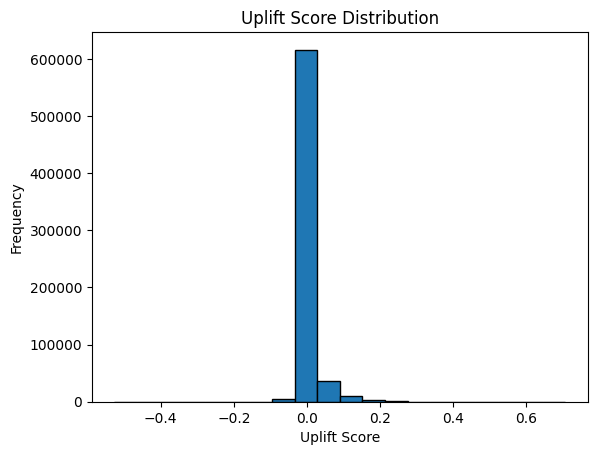

In [ ]:
plt.hist(uplift_tm, bins=20, edgecolor='black')
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Uplift Score Distribution')
plt.show()

In [ ]:
# uplift_tm을 Numpy 배열로 변환
df_uplift = pd.DataFrame({'uplift_score': np.array(uplift_tm)})
df_uplift

,uplift_score
0,0.000442
1,0.000187
2,0.002777
3,0.000226
4,0.000172
...,...
671015,0.000214
671016,-0.001051
671017,0.000199
671018,0.000884


In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,TwoModels,0.033306
